In [1]:
%matplotlib ipympl

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [3]:
# Earth's radius
Re = 6371e3 # m

In [4]:
def latlon2xyz(lat, lon):
    """Converts latitude and longitude to cartesian coordinates

    Args:
        lat (float): Latitude in degrees
        lon (float): Longitude in degrees

    Returns:
        float: x, y, z coordinates
    """
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    x = Re * np.cos(lat) * np.cos(lon)
    y = Re * np.cos(lat) * np.sin(lon)
    z = Re * np.sin(lat)
    return np.array([x, y, z])

In [5]:
P_coords = (87.77068264201536, -77.42315118963069) # Northern hemisphere
# P_coords = (0, 0)
P = latlon2xyz(*P_coords)
crs = 270 # Course in degrees, to the north west
print(f"Cart. P: {P}")

Cart. P: [  53963.88834528 -241879.60450334 6366178.06503085]


In [6]:
def get_true_north_pointing_vector(P: np.ndarray) -> np.ndarray:
    """Get the true north pointing vector at a given point P

    Args:
        P (np.ndarray): Point P in cartesian coordinates

    Returns:
        np.ndarray: True north pointing vector
    """
    x, y, z = P
    north = np.array([-x * z, -y * z, x**2 + y**2])
    return north / np.linalg.norm(north)

def course_equation(vars, xp, yp, zp, xn, yn, zn, crs):
    xc, yc, zc = vars
    eq1 = xp * xc + yp * yc + zp * zc # Course vector is perpendicular to the OP vector
    eq2 = xn * xc + yn * yc + zn * zc - np.cos(np.deg2rad(crs)) # Course vector forms an angle of crs with the true north vector
    eq3 = xc**2 + yc**2 + zc**2 - 1 # Course vector is a unit vector
    return eq1, eq2, eq3

def get_course_vector(P: np.ndarray, crs: float) -> np.ndarray:
    """Get the course vector at a given point P

    Args:
        P (np.ndarray): Point P in cartesian coordinates
        crs (float): Course in degrees

    Returns:
        np.ndarray: Course vector
    """
    north = get_true_north_pointing_vector(P)
    xp, yp, zp = P / np.linalg.norm(P)
    xn, yn, zn = north
    
    if crs > 0 and crs < 180:
        c0 = np.cross(north, P) / np.linalg.norm(np.cross(north, P)) # initial guess is the East vector
    else:
        c0 = np.cross(P, north) / np.linalg.norm(np.cross(P, north)) # initial guess is the West vector
    
    c = fsolve(course_equation, c0, args=(xp, yp, zp, xn, yn, zn, crs))

    
    return c / np.linalg.norm(c)

def get_second_vector_in_GC(P: np.ndarray, c: np.ndarray) -> np.ndarray:
    """Get the second vector in the great circle defined by the course vector

    Args:
        P (np.ndarray): Point P in cartesian coordinates
        c (np.ndarray): Course vector

    Returns:
        np.ndarray: Second vector in the great circle
    """
    s = np.cross(np.cross(P, c), P)
    return s / np.linalg.norm(s)

def get_course_vector_on_GC(P: np.ndarray, s: np.ndarray, P0: np.ndarray) -> np.ndarray:
    """Get the course vector on the great circle defined by the second vector

    Args:
        P (np.ndarray): Point P in cartesian coordinates (perturbed P0)
        s (np.ndarray): Second vector in the great circle
        P0 (np.ndarray): The original point P in cartesian coordinates, to ensure the course vector is pointing in the right direction

    Returns:
        np.ndarray: Course vector on the great circle
    """
    normal_vec_of_GC = np.cross(P0, s)
    c = np.cross(normal_vec_of_GC, P)
    return c/np.linalg.norm(c)

In [7]:
# Get the course vector
c = get_course_vector(P, crs)
n = get_true_north_pointing_vector(P)
s = get_second_vector_in_GC(P, c)
print(f"c: {c}")
print(f"n: {n}")
print(f"s: {s}")

# Verify that the course vector is perpendicular to the OP vector
print(f"<OP, c>: {np.dot(P, c)} approx. 0?")
# Verify that the course vector forms an angle of crs with the true north vector
north = get_true_north_pointing_vector(P)
angle = np.rad2deg(np.arccos(np.dot(north, c)))
if (c[1] < 0 and angle < 180) or (c[1] > 0 and angle > 180):
    angle = 360 - angle
    
print(f"Angle between c and n: {angle} approx. {crs}?")

c: [-9.76004826e-01 -2.17748890e-01 -8.87906137e-18]
n: [-0.21758409  0.97526613  0.03889911]
s: [-9.76004826e-01 -2.17748890e-01 -7.51856320e-18]
<OP, c>: -1.4551915228366852e-11 approx. 0?
Angle between c and n: 270.0 approx. 270?


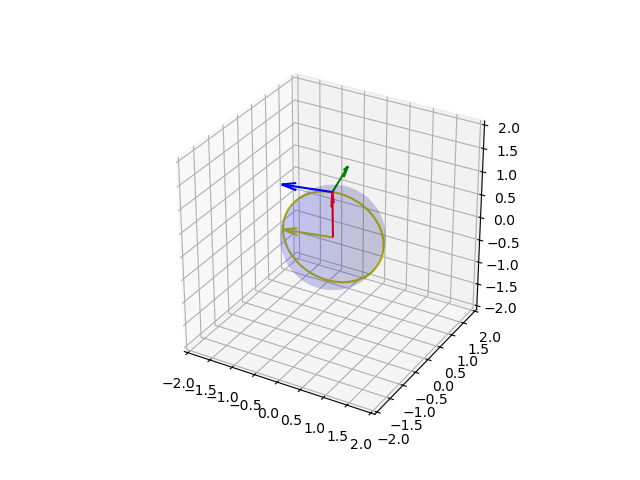

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.quiver(0, 0, 0, P[0], P[1], P[2], color='r')
# ax.quiver(0, 0, 0, c[0], c[1], c[2], color='b')
ax.quiver(P[0]/Re, P[1]/Re, P[2]/Re, c[0], c[1], c[2], color='b')
ax.quiver(P[0]/Re, P[1]/Re, P[2]/Re, n[0], n[1], n[2], color='g')
# ax.quiver(P[0]/Re, P[1]/Re, P[2]/Re, P[0]/Re+n[0], P[1]/Re+n[1], P[2]/Re+n[2], color='b')
ax.quiver(0, 0, 0, P[0]/Re, P[1]/Re, P[2]/Re, color='r')
ax.quiver(0, 0, 0, s[0], s[1], s[2], color='y')

# Plot the Earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)

# Plot the great circle
theta = np.linspace(0, 2 * np.pi, 100) # central angle
x = P[0]/Re * np.cos(theta) + s[0] * np.sin(theta)
y = P[1]/Re * np.cos(theta) + s[1] * np.sin(theta)
z = P[2]/Re * np.cos(theta) + s[2] * np.sin(theta)
ax.plot(x, y, z, color='y')


ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_box_aspect([1,1,1])

plt.ion()
plt.show()

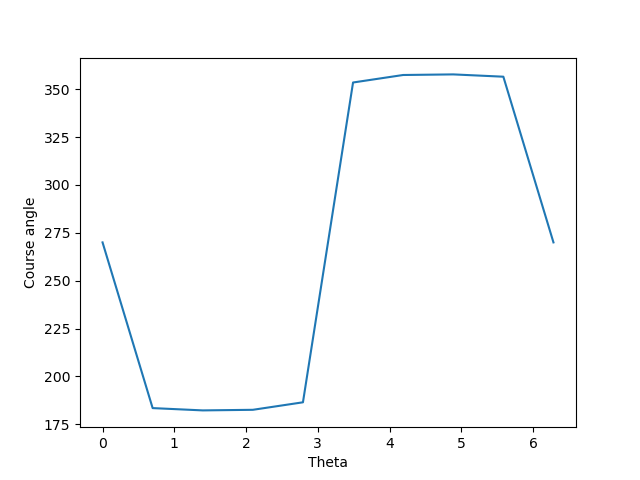

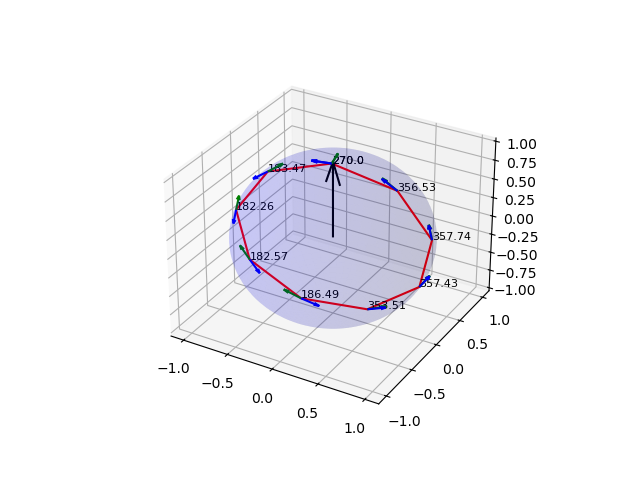

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)

# Plot the North pole
ax.quiver(0, 0, 0, 0, 0, 1, color='black')

N_pts = 10
crs_on_gc = np.zeros(N_pts)
i = 0
theta = np.linspace(0, 2 * np.pi, N_pts)
P_prime = np.zeros((3, N_pts))
P_prime[0,:] = P[0] * np.cos(theta) + s[0] * Re * np.sin(theta)
P_prime[1,:] = P[1] * np.cos(theta) + s[1] * Re * np.sin(theta)
P_prime[2,:] = P[2] * np.cos(theta) + s[2] * Re * np.sin(theta)

ax.plot(P_prime[0]/Re, P_prime[1]/Re, P_prime[2]/Re, color='r')

for t in range(N_pts):
    #P_prime[:, t] = P * np.cos(theta[t]) + s * Re * np.sin(theta[t])
    # Get the new North vector
    n_prime = get_true_north_pointing_vector(P_prime[:, t])
    # print(np.linalg.norm(n_prime))
    ax.quiver(P_prime[0, t]/Re, P_prime[1, t]/Re, P_prime[2, t]/Re, n_prime[0]/5, n_prime[1]/5, n_prime[2]/5, color='g')
    # print(f"n': {n_prime}")
    # Get the new course vector
    c_prime = get_course_vector_on_GC(P_prime[:, t], s, P)
    ax.quiver(P_prime[0, t]/Re, P_prime[1, t]/Re, P_prime[2, t]/Re, c_prime[0]/5, c_prime[1]/5, c_prime[2]/5, color='b')
    # print(f"{np.linalg.norm(c_prime)}")
    # print(f"c: {c}")
    angle = np.rad2deg(np.arccos(np.dot(n_prime, c_prime)))
    # We must differentiate between the two possible angles: negative and positive since the dot product is symmetric (does not reveal the direction of multiplication)
    # The idea is to compute the cross product between n_prime and c_prime, if the product is in the same direction as P', then the angle is positive (<180)
    # Otherwise, the angle is negative (>180)
    crx_nc = np.cross(n_prime, c_prime)
    if np.dot(crx_nc, P_prime[:, t]) > 0:
        angle = 360 - angle
        
        
    ax.text(P_prime[0, t]/Re, P_prime[1, t]/Re, P_prime[2, t]/Re, f'{round(angle,2)}', fontsize=8)

    
    crs_on_gc[i] = angle
    i += 1

plt.figure()
plt.plot(np.linspace(0, 2 * np.pi, N_pts), crs_on_gc)
plt.xlabel('Theta')
plt.ylabel('Course angle')
plt.show()


In [10]:
theta = 1e3/Re # 1 km for differentiation
P_prime = P * np.cos(theta) + s * Re * np.sin(theta)

n_prime = get_true_north_pointing_vector(P_prime)
c_prime = get_course_vector_on_GC(P_prime, s, P)
angle = np.rad2deg(np.arccos(np.dot(n_prime, c_prime)))
if (c_prime[1] < 0 and angle < 180) or (c_prime[1] > 0 and angle > 180):
    angle = 360 - angle

d_angle = (angle - crs) / 1 # degrees per kilometer travel
print(f"Angle: {angle}")
print(f"d_angle: {d_angle}")

Angle: 269.7689828778937
d_angle: -0.23101712210632286


In [11]:
from drift_compensation import get_track_drift_rate
print(get_track_drift_rate(P_coords[0], P_coords[1], crs))

-0.23089321123703713
